In [38]:
import os

from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [39]:
train_dir='E:/practise_data/train'
validation_dir='E:/practise_data/validation'

FOR MORE INFO ABOUT DATAGENERATOR AND AGUMENTATION AND RELATED ARGUMENTS.....
---->>>>https://keras.io/preprocessing/image/

In [40]:
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)


test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [41]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = 'E:/weights/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False
  
pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output


from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['acc'])


Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_564 (Conv2D)             (None, 74, 74, 32)   864         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_564 (BatchN (None, 74, 74, 32)   96          conv2d_564[0][0]                 
__________________________________________________________________________________________________
activation_564 (Activation)     (None, 74, 74, 32)   0           batch_normalization_564[0][0]    
_______________________________________________________________________________________

In [28]:
history = model.fit_generator(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 20,
            validation_steps = 50,
            verbose = 2)

Epoch 1/20
100/100 - 58s - loss: 0.5078 - acc: 0.7550 - val_loss: 0.2804 - val_acc: 0.9150
Epoch 2/20
100/100 - 16s - loss: 0.3883 - acc: 0.8200 - val_loss: 0.3193 - val_acc: 0.9230
Epoch 3/20
100/100 - 16s - loss: 0.3480 - acc: 0.8525 - val_loss: 0.2138 - val_acc: 0.9540
Epoch 4/20
100/100 - 16s - loss: 0.3168 - acc: 0.8675 - val_loss: 0.4235 - val_acc: 0.9260
Epoch 5/20
100/100 - 15s - loss: 0.3112 - acc: 0.8770 - val_loss: 0.7198 - val_acc: 0.9070
Epoch 6/20
100/100 - 19s - loss: 0.3232 - acc: 0.8700 - val_loss: 0.3375 - val_acc: 0.9470
Epoch 7/20
100/100 - 16s - loss: 0.3233 - acc: 0.8605 - val_loss: 0.3834 - val_acc: 0.9420
Epoch 8/20
100/100 - 16s - loss: 0.2801 - acc: 0.8755 - val_loss: 0.3341 - val_acc: 0.9530
Epoch 9/20
100/100 - 15s - loss: 0.2877 - acc: 0.8755 - val_loss: 0.3506 - val_acc: 0.9500
Epoch 10/20
100/100 - 17s - loss: 0.2920 - acc: 0.8815 - val_loss: 0.5383 - val_acc: 0.9320
Epoch 11/20
100/100 - 19s - loss: 0.2713 - acc: 0.8990 - val_loss: 0.3383 - val_acc: 0.95

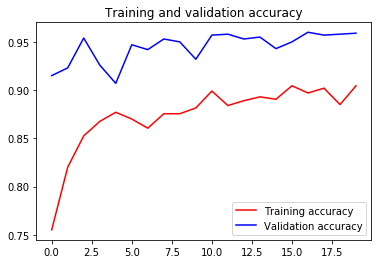

<Figure size 432x288 with 0 Axes>

In [29]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

"Further Improving Accuracy with Fine-Tuning"

In our feature-extraction experiment, we only tried adding two classification layers on top of an Inception V3 layer. The weights of the pretrained network were not updated during training. One way to increase performance even further is to "fine-tune" the weights of the top layers of the pretrained model alongside the training of the top-level classifier. A couple of important notes on fine-tuning:

    Fine-tuning should only be attempted after you have trained the top-level classifier with the pretrained model set to non-trainable. If you add a randomly initialized classifier on top of a pretrained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier), and your pretrained model will just forget everything it has learned.
    Additionally, we fine-tune only the top layers of the pre-trained model rather than all layers of the pretrained model because, in a convnet, the higher up a layer is, the more specialized it is. The first few layers in a convnet learn very simple and generic features, which generalize to almost all types of images. But as you go higher up, the features are increasingly specific to the dataset that the model is trained on. The goal of fine-tuning is to adapt these specialized features to work with the new dataset.

All we need to do to implement fine-tuning is to set the top layers of Inception V3 to be trainable, recompile the model (necessary for these changes to take effect), and resume training. Let's unfreeze all layers belonging to the mixed7 module—i.e., all layers found after mixed6—and recompile the model:

In [31]:
from tensorflow.keras.optimizers import SGD

unfreeze = False

# Unfreeze all models after "mixed6"
for layer in pre_trained_model.layers:
  if unfreeze:
    layer.trainable = True
  if layer.name == 'mixed6':
    unfreeze = True

# As an optimizer, here we will use SGD 
# with a very low learning rate (0.00001)
model.compile(loss='binary_crossentropy',
              optimizer=SGD(
                  lr=0.00001, 
                  momentum=0.9),
              metrics=['acc'])

In [32]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=50,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Epoch 1/50
100/100 - 21s - loss: 0.2325 - acc: 0.9050 - val_loss: 0.4248 - val_acc: 0.9560
Epoch 2/50
100/100 - 16s - loss: 0.2241 - acc: 0.9100 - val_loss: 0.4356 - val_acc: 0.9550
Epoch 3/50
100/100 - 16s - loss: 0.2259 - acc: 0.9120 - val_loss: 0.4415 - val_acc: 0.9550
Epoch 4/50
100/100 - 17s - loss: 0.2261 - acc: 0.9075 - val_loss: 0.4470 - val_acc: 0.9550
Epoch 5/50
100/100 - 16s - loss: 0.2356 - acc: 0.9100 - val_loss: 0.4425 - val_acc: 0.9540
Epoch 6/50
100/100 - 15s - loss: 0.2151 - acc: 0.9150 - val_loss: 0.4469 - val_acc: 0.9550
Epoch 7/50
100/100 - 18s - loss: 0.2060 - acc: 0.9180 - val_loss: 0.4439 - val_acc: 0.9550
Epoch 8/50
100/100 - 17s - loss: 0.2123 - acc: 0.9165 - val_loss: 0.4403 - val_acc: 0.9540
Epoch 9/50
100/100 - 16s - loss: 0.2131 - acc: 0.9130 - val_loss: 0.4428 - val_acc: 0.9540
Epoch 10/50
100/100 - 16s - loss: 0.2280 - acc: 0.9080 - val_loss: 0.4405 - val_acc: 0.9550
Epoch 11/50
100/100 - 15s - loss: 0.2001 - acc: 0.9170 - val_loss: 0.4417 - val_acc: 0.95

Text(0.5, 1.0, 'Training and validation loss')

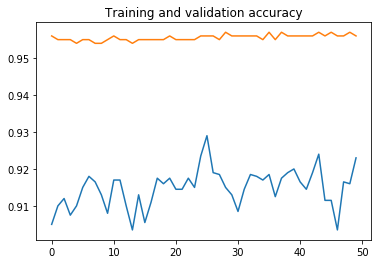

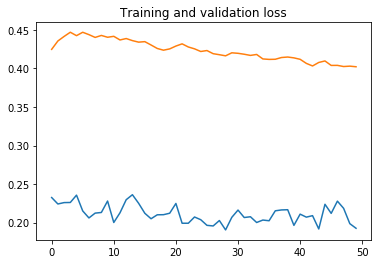

In [33]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')